Источник данных https://www.kaggle.com/datasets/timmate/avocado-prices-2020

# Продажи авокадо в США с 2015 по 2021 гг. 

### Некоторые соответствующие столбцы в наборе данных:  

**date** – дата наблюдения.  
**AveragePrice** — средняя цена одного авокадо.  
**type** – обычный или органический  
**year** - год  
**geography** - город или регион наблюдения  
**total value** – общее количество проданных авокадо.  
**4046** – Общее количество проданных авокадо с PLU 4046.  
**4225** — Общее количество проданных авокадо с PLU 4225.  
**4770** — Общее количество проданных авокадо с PLU 4770.  

In [1]:
# Библиотеки для обработки данных
import pandas as pd
import numpy as np

# Обработка предупреждений
import warnings

# База данных SQLite
import sqlite3

# Библиотека для работы со статистикой
import scipy.stats as st

# Библиотеки для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns

#Библиотека для нормализации данных
from sklearn.preprocessing import Normalizer, StandardScaler

In [89]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 200)

sns.color_palette()
plt.style.use('ggplot')

## Гипотезы:
1. В зимний период средняя цена авокадо выше (или меньше), чем в летний (зимний период: ноябрь - март, летний период: май - сентябрь).  
    **H0 - Цена относительно времени года не меняется.**  
    
    
2. Органических авокадо продается меньше, чем обычных.  
    **Н0 - Количество обычных авокадо продается столько же сколько и органических.**  
    
    
3. Калифорния закупает больше (или меньше авокадо) авокадо, чем Южная Каролина.  
    **Н0 - Калифорния закупает столько же, чем Южная Каролина.** 

## Подготовка данных

In [3]:
total_us = """SELECT date, average_price, total_volume, type_, location FROM main m
	LEFT JOIN "type" t ON m."type" = t.t_id 
	LEFT JOIN geography g ON m.geography  = g.g_id 
	LEFT JOIN location l ON g.type_of_location = l.l_id 
	WHERE location = 'country';"""

total_states = """SELECT date, average_price, total_volume, type_, geo, location FROM main m
	LEFT JOIN "type" t ON m."type" = t.t_id 
	LEFT JOIN geography g ON m.geography  = g.g_id 
	LEFT JOIN location l ON g.type_of_location = l.l_id 
	WHERE location = 'state';"""

In [4]:
data_total_us = pd.read_sql_query(total_us, sqlite3.connect('avocado.db'))
data_total_states = pd.read_sql_query(total_states, sqlite3.connect('avocado.db'))

In [5]:
data_total_us.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 612 entries, 0 to 611
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           612 non-null    object 
 1   average_price  612 non-null    float64
 2   total_volume   612 non-null    float64
 3   type_          612 non-null    object 
 4   location       612 non-null    object 
dtypes: float64(2), object(3)
memory usage: 24.0+ KB


In [6]:
data_total_us_with_dt = data_total_us.copy()
data_total_us_with_dt.date = pd.to_datetime(data_total_us_with_dt.date)

In [7]:
def f_test(A, B):
    f = np.var(A, ddof=1)/np.var(B, ddof=1)
    nun = A.size-1
    dun = B.size-1
    p_value = 1-st.f.cdf(f, nun, dun)
    
    if p_value >= .05:
        return 'Дисперсии, вероятно, одинаковы.'
    return 'Дисперсии, вероятно, разные.'

In [8]:
def shapiro(A):
    stat, p = st.shapiro(A)
    if p >= .05:
        return 'Вероятно выборка не из нормального распределения.'
    return 'Вероятно выборка из нормального распределения.'

In [9]:
def mw_test(A, B):
    stat, p = st.mannwhitneyu(A, B)
    
    if p >= .05:
        return 'Н0 не отклоняем, средние, вероятно, одинаковы.'
    return 'Н0 отклоняем, средние, вероятно, разные.'

In [10]:
def t_test(A, B):
    stat, p = st.ttest_ind(A, B)
    
    if p >= .05:
        return 'Н0 не отклоняем, средние, вероятно, одинаковы.'
    return 'Н0 отклоняем, средние, вероятно, разные.'

## Анализ признаков

In [11]:
data = data_total_us_with_dt[data_total_us_with_dt.type_ != 'organic']

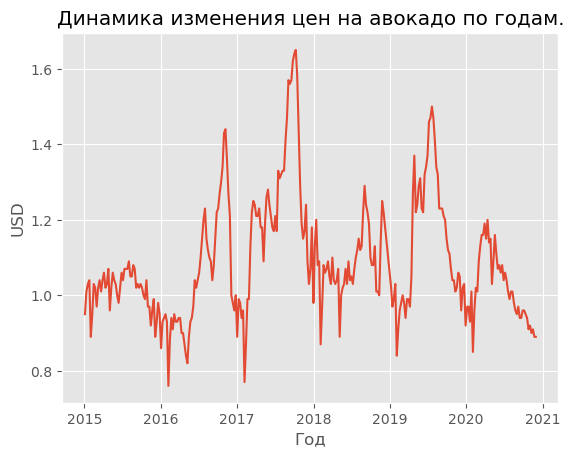

In [91]:
plt.plot(data.date, data.average_price)
plt.title('Динамика изменения цен на авокадо по годам.')
plt.ylabel('USD')
plt.xlabel('Год')
plt.show()

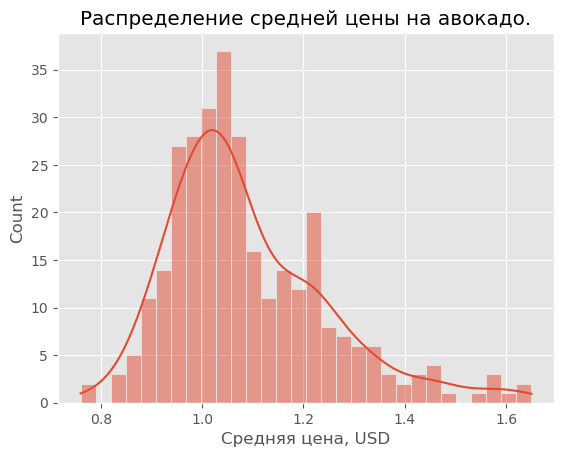

In [152]:
sns.histplot(data.average_price, bins=30, kde=True)
plt.title('Распределение средней цены на авокадо.')
plt.xlabel('Средняя цена, USD')
plt.show()

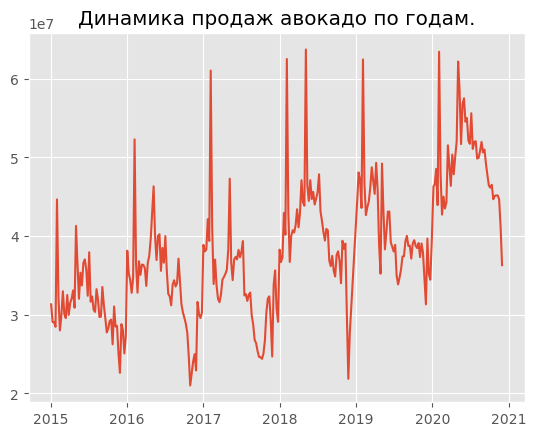

In [93]:
plt.plot(data.date, data.total_volume)
plt.title('Динамика продаж авокадо по годам.')
plt.show()

In [94]:
data_15 = data[(data.date >= '2016-01-01') & (data.date <= '2016-12-31')]

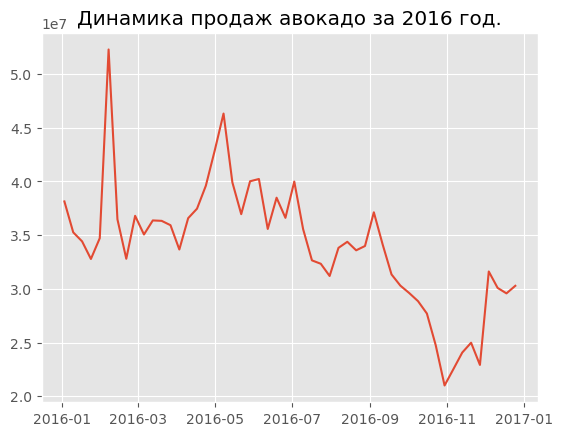

In [95]:
plt.plot(data_15.date, data_15.total_volume)
plt.title('Динамика продаж авокадо за 2016 год.')
plt.show()

### Проверка первой гипотезы:
В зимний период средняя цена авокадо выше, чем в летний (зимний период: ноябрь - март, летний период: май - сентябрь).

In [96]:
summer = data_total_us[(data_total_us.date >= '2015-05-01') & (data_total_us.date <= '2015-09-30') & 
                      (data_total_us.type_ != 'organic')]
for i in range(1, 7):
    summer = pd.concat([summer, data_total_us[(data_total_us.date >= f'201{5+i}-05-01') & (data_total_us.date <= f'201{5+i}-09-30') & 
                      (data_total_us.type_ != 'organic')]])

In [97]:
winter = data_total_us[(data_total_us.date >= '2015-11-01') & (data_total_us.date <= '2016-03-30') & 
                      (data_total_us.type_ != 'organic')]
for i in range(1, 7):
    winter = pd.concat([winter, data_total_us[(data_total_us.date >= f'201{5+i}-11-01') & (data_total_us.date <= f'201{6+i}-03-30') & 
                      (data_total_us.type_ != 'organic')]])

Перед использованием Т-теста Стьюдента проерим нормальность распределенй. 

In [98]:
shapiro(summer.average_price)

'Вероятно выборка из нормального распределения.'

In [99]:
shapiro(winter.average_price)

'Вероятно выборка из нормального распределения.'

Из-за того, что наши распределения нормальные, мы будем использовать критерий Стьюдента для проверки гипотезы. 

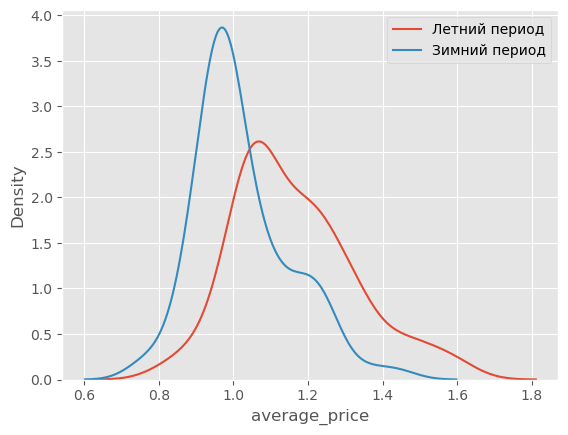

In [100]:
sns.kdeplot(summer.average_price, label='Летний период')
sns.kdeplot(winter.average_price, label='Зимний период')
plt.legend()
plt.show()

In [101]:
t_test(summer.average_price, winter.average_price)

'Н0 отклоняем, средние, вероятно, разные.'

### Проверка второй гипотезы
Органических авокадо продается меньше, чем обычных.

In [102]:
organic = data_total_us[data_total_us.type_ == 'organic']
conventional = data_total_us[data_total_us.type_ == 'conventional']

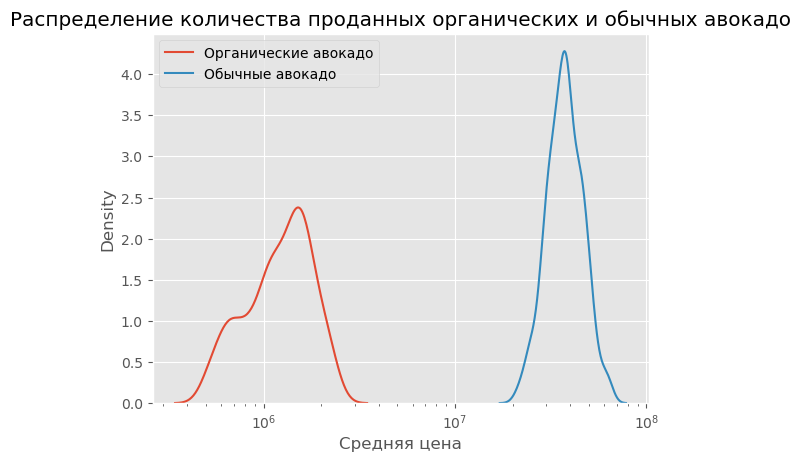

In [103]:
sns.kdeplot(organic.total_volume, label='Органические авокадо', log_scale=True)
sns.kdeplot(conventional.total_volume, label='Обычные авокадо', log_scale=True)
plt.legend()
plt.title('Распределение количества проданных органических и обычных авокадо')
plt.xlabel('Средняя цена')
plt.show()

Перед использованием Т-теста Стьюдента проерим нормальность распределений.

In [104]:
shapiro(conventional.total_volume)

'Вероятно выборка из нормального распределения.'

In [105]:
shapiro(organic.total_volume)

'Вероятно выборка из нормального распределения.'

In [106]:
t_test(conventional.total_volume, organic.total_volume)

'Н0 отклоняем, средние, вероятно, разные.'

### Проверка третьей гипотезы
Калифорния закупает больше авокадо, чем Южная Каролина.

In [107]:
california = data_total_states[(data_total_states.geo == 'California') & 
                              (data_total_states.type_ != 'organic')]
south_carolina = data_total_states[(data_total_states.geo == 'South Carolina') & 
                           (data_total_states.type_ != 'organic')]

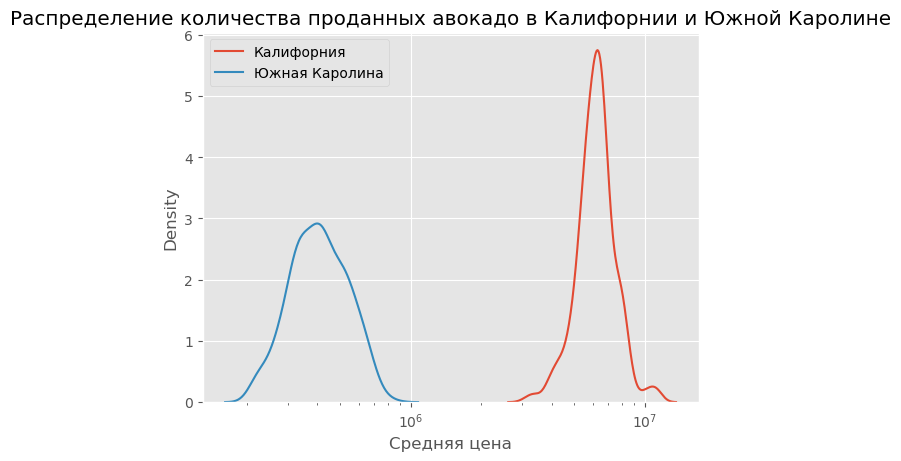

In [108]:
sns.kdeplot(california.total_volume, label='Калифорния', log_scale=True)
sns.kdeplot(south_carolina.total_volume, label='Южная Каролина', log_scale=True)
plt.legend()
plt.title('Распределение количества проданных авокадо в Калифорнии и Южной Каролине')
plt.xlabel('Средняя цена')
plt.show()

Перед использованием Т-теста Стьюдента проерим нормальность распределений.

In [109]:
shapiro(california.total_volume)

'Вероятно выборка из нормального распределения.'

In [110]:
shapiro(south_carolina.total_volume)

'Вероятно выборка из нормального распределения.'

In [111]:
t_test(california.total_volume, south_carolina.total_volume)

'Н0 отклоняем, средние, вероятно, разные.'

## Выводы

1. Средняя цена обычного авокадо за период 2015-2021 года варьировалась в диапазоне от 0.8 до 1.7 USD. При этом цена во времени изменялась с четкой периодичностью (падение цен в начале года и рост в конце).  
2. Динамика продаж обычного авокадо за период 2015-2021 года изменялась также с просматривающейся закономерностью (высокие продажи в начале года, низкие продажи к концу).  
3. Первая гипотеза о ценах в зимний и летний период: Н0 - отклонена, Н1 - не отклонена, то есть средняя цена обычного авокадо в зимний и летний период отличается.  
4. Вторая гипотеза о количестве проданых органических и обычных авокадо: Н0 - отклонена, Н1 - не отклонена, то есть обычный авокадо продается в большем количестве, чем органический. 
5. Третья гипотеза о количестве проданных обычных авокадо в Калифорнии и Южной Каролине: Н0 - отклонена, Н1 - не отклонена, то есть среднее количество закупаемых авокадо в Калифорнии отличается от количества в Южной Каролине. 

In [299]:
data_regression = data[['date', 'average_price']]

In [300]:
data_regression

,date,average_price
0,2015-01-04,0.95
2,2015-01-11,1.01
4,2015-01-18,1.03
6,2015-01-25,1.04
8,2015-02-01,0.89
...,...,...
602,2020-11-01,0.92
604,2020-11-08,0.90
606,2020-11-15,0.91
608,2020-11-22,0.89


In [301]:
data_regression.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 306 entries, 0 to 610
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           306 non-null    datetime64[ns]
 1   average_price  306 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.3 KB


In [289]:
# data_regression['year'] = data_regression.index.year
# data_regression['month'] = data_regression.index.month_name()
# data_regression['day_of_year'] = data_regression.index.day_of_year

In [302]:
data_regression['year'] = data_regression.date.dt.year
data_regression['month'] = data_regression.date.dt.month_name()
data_regression['day_of_year'] = data_regression.date.dt.day_of_year

In [303]:
from sklearn.model_selection import train_test_split

In [304]:
from sklearn.preprocessing import LabelEncoder

In [305]:
le = LabelEncoder()

In [306]:
data_regression.month = le.fit_transform(data_regression.month)

In [390]:
# X_tr, X_t, y_tr, y_t = train_test_split(data_regression, y, test_size=.2, random_state=42)

X_t = data_regression.loc[data_regression['date'] >= '2020-01-01']
X_t.set_index('date', inplace=True)
y_t = X_t['average_price']
del X_t['average_price']

X_tr = data_regression.loc[data_regression['date'] < '2020-01-01']
X_tr.set_index('date', inplace=True)
y_tr = X_tr['average_price']
del X_tr['average_price']

In [391]:
X_tr

,year,month,day_of_year
date,,,
2015-01-04,2015,4,4
2015-01-11,2015,4,11
2015-01-18,2015,4,18
2015-01-25,2015,4,25
2015-02-01,2015,3,32
...,...,...,...
2019-12-01,2019,2,335
2019-12-08,2019,2,342
2019-12-15,2019,2,349


In [392]:
from sklearn.ensemble import 

In [393]:
model = RandomForestRegressor()

In [394]:
model.fit(X_tr, y_tr)

RandomForestRegressor()

In [395]:
y_p = model.predict(X_t)

In [396]:
comp = pd.DataFrame(y_t)

In [397]:
y_ = pd.DataFrame(y_p)

In [398]:
comp['av_pr_p'] = y_p

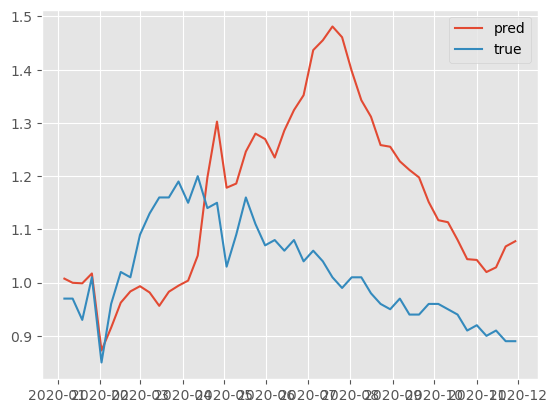

In [399]:
plt.plot(comp.av_pr_p, label='pred')
plt.plot(comp.average_price, label='true')
plt.legend()